In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt

from KAGGLE_NLP_with_disaster_tweets.model import base_model, constants, utils
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

In [2]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

In [3]:
data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name, output_sequence_length=140, vocabulary_size=constants.parameters["vocabulary_size"])
dataset, submission_test_dataset = data_pipeline.prepare_datasets()

2022-01-27 00:51:31.878427: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-27 00:51:31.878461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sersery-asusVivo
2022-01-27 00:51:31.878468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sersery-asusVivo
2022-01-27 00:51:31.878547: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-27 00:51:31.878571: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-27 00:51:31.878577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-27 00:51:31.878923: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU 

Getting the file: ../data/train.csv
-----------------------------------------------------------------------------------------
Dataset 
Size: 7613
Dataset examples:
Input: [  58   77 1933    1    1    1  803   58  151   77    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
Target: [0. 1.]
Input: [ 250  763  527    8 3186    2  250    5   13 1964    1  751    0    0
    0    0    0    0    

In [4]:
dataframe = data_pipeline.dataframe
isTrueCount = dataframe["target"].where(dataframe["target"] == 1).count()
isFalseCount = dataframe["target"].where(dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3271 | 42.965979246026535% of data
False instances: 4342 | 57.034020753973465% of data


In [5]:
print(f"Vocabulary size: {constants.parameters['vocabulary_size']}")

Vocabulary size: 5001


In [6]:
balanced_class_weights = utils.get_balanced_class_weights(dataframe)

In [7]:
batch_size = 32
constants.parameters["epochs"] = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

hparams = {
    constants.hyperparameters["optimizer"]: "adamw",
    constants.hyperparameters["hidden_unit"]: 32,
    constants.hyperparameters["batch_size"]: batch_size,
    constants.hyperparameters["learning_rate"]: 1e-3,
    constants.hyperparameters["class_weights"]: "balanced",
    constants.hyperparameters["dropout"]: 0.1
}

model = base_model.BaseModel(batch_pipeline=BatchPipeline(dataset, submission_test_dataset, batch_size),
                   parameters=constants.parameters,
                   hyperparameters=constants.hyperparameters,
                   hparams=hparams,
                   class_weights=balanced_class_weights)

accuracy, precision, recall, f1 = model.fit_and_evaluate(log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160032    
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         6272      
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 32)          1056      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 6

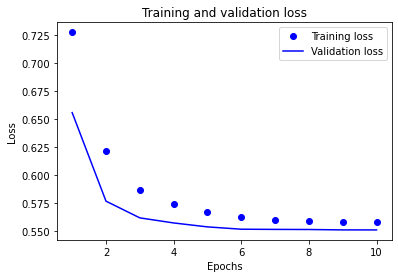

In [8]:
history_dict = model.history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

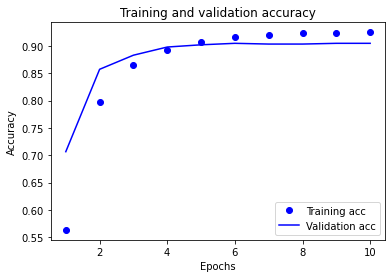

In [9]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### We try a larger dropout

In [10]:
batch_size = 32
constants.parameters["epochs"] = 10
log_directory = "./logs/hyperparameter_tuning_BaseModel/"

hparams = {
    constants.hyperparameters["optimizer"]: "adamw",
    constants.hyperparameters["hidden_unit"]: 32,
    constants.hyperparameters["batch_size"]: batch_size,
    constants.hyperparameters["learning_rate"]: 1e-3,
    constants.hyperparameters["class_weights"]: "balanced",
    constants.hyperparameters["dropout"]: 0.5
}

model = base_model.BaseModel(batch_pipeline=BatchPipeline(dataset, submission_test_dataset, batch_size),
                   parameters=constants.parameters,
                   hyperparameters=constants.hyperparameters,
                   hparams=hparams,
                   class_weights=balanced_class_weights)

accuracy, precision, recall, f1 = model.fit_and_evaluate(log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          160032    
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 32)         6272      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, None, 32)          1056      
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                

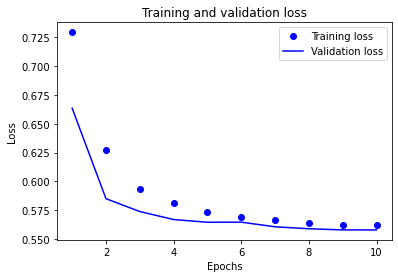

In [11]:
history_dict = model.history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

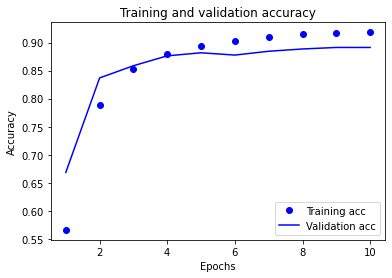

In [12]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [13]:
# batch_pipeline = BatchPipeline(dataset, submission_test_dataset, batch_size)
# predictions = base_model.predict_for_kaggle(batch_pipeline.submission_test_dataset)
# print(f"Predictions: {predictions}")

In [14]:
# submission_test_dataframe = data_pipeline.get_dataframe_from_csv(sample_submission_file_name).fillna(" ")
#
# utils.create_submission_for_kaggle("kaggle_predictions_BaseModel.txt", submission_test_dataframe["id"].values, predictions)

In [15]:
# %load_ext tensorboard

In [16]:
# tensorboard --logdir logs/hyperparameter_tuning --port 5000